In [1]:
%load_ext autoreload
%autoreload 1
%matplotlib notebook

In [330]:
import sys, os
os.environ['DDEBACKEND'] = 'pytorch'
import numpy as np
import matplotlib.pyplot as plt

%aimport mre_pinn

# Traveling wave forward problem

The linear viscoelastic wave equation is as follows:

$$
\begin{align}
    \nabla \cdot \sigma &= \rho \mathbf{u}_{tt}
\end{align}
$$

Where strain is defined as:

$$
\begin{align}
    \sigma &= \mu \left( \nabla \mathbf{u} + (\nabla \mathbf{u})^\top \right) + \lambda (\nabla \cdot \mathbf{u}) \mathbf{I}
\end{align}
$$

We can discretize as follows:


$$
\begin{align}
    \nabla \cdot \sigma^k &= \rho \frac{\mathbf{u}^{k+1} - 2 \mathbf{u}^k + \mathbf{u}^{k-1}}{dt^2} \\
    \frac{dt^2}{\rho} \nabla \cdot \sigma^k &= \mathbf{u}^{k+1} - 2 \mathbf{u}^k + \mathbf{u}^{k-1} \\
    \mathbf{u}^{k+1} &= \frac{dt^2}{\rho} \nabla \cdot \sigma^k + 2 \mathbf{u}^k - \mathbf{u}^{k-1} \\
\end{align}
$$

Which we can solve once we provide sufficient initial and boundary conditions.

20001 201 201


<IPython.core.display.Javascript object>


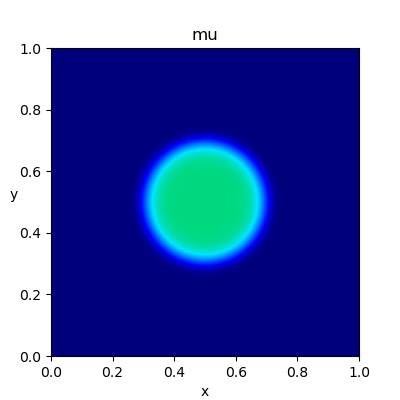

In [109]:
# temporal resolution

len_t = 10 # seconds
dt = 0.0005 # seconds
n_t = int(len_t / dt + 1)
n_periods = np.inf

# spatial resolution

len_x = 1 # meters
dx = 0.005 # meters
n_x = int(len_x / dx + 1)

len_y = 1 # meters
dy = 0.005 # meters
n_y = int(len_y / dy + 1)

print(n_t, n_x, n_y)

# physical parameters

rho = 1 # 1000 * kilogram / meter^2
omega = 10 * (2 * np.pi) # radians
A = 0.001 # meters
mu_back = 10
lam_back = 0

# disk-shaped inclusion

mu_disk = 50
lam_disk = lam_back
loc = (0.5, 0.5)
radius = 0.2

mu  = np.full((n_x, n_y), mu_back)
lam = np.full((n_x, n_y), lam_back)

x = np.linspace(0, len_x, n_x)
y = np.linspace(0, len_y, n_y)
x, y = np.meshgrid(x, x)
dist = np.sqrt((x - loc[0])**2 + (y - loc[1])**2)
disk = np.exp(-(dist/radius)**8)
mu  = mu + disk * (mu_disk - mu_back)
lam = mu + disk * (lam_disk - lam_back)

# display elasticity field

def view2d(a, len_x, len_y, title, ax, **kwargs):
    extent = (0, len_x, 0, len_y)
    im = ax.imshow(a, extent=extent, resample=False, **kwargs)
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y', rotation=0)
    return im

e_map = mre_pinn.visual.elast_color_map()
e_min =   0
e_max = 100

fig, ax = plt.subplots(1, 1, figsize=(4*len_x, 4*len_y))
view2d(mu, len_x, len_y, title='mu', ax=ax, vmin=e_min, vmax=e_max, cmap=e_map)

In [110]:
%%time

import tqdm

# simulate wave field
u = np.zeros((n_t, n_x, n_y, 2))

nax = np.newaxis
for k in tqdm.tqdm(range(n_t-1)):
    
    # boundary conditions
    t = k * dt
    if omega * t < 2*np.pi * n_periods:
        u[k,0,:,0] = A * np.sin(omega*t)
    else:
        u[k,0,:,0] = 0
    u[k,0,:,1]  = 0
    u[k,-1,:,:] = 0
    u[k,:,0,:]  = u[k,:,-2,:]
    u[k,:,-1,:] = u[k,:,1,:]
    
    if k < 1: # need two initial time steps
        continue
    
    # forward step
    grad_ux = np.stack(np.gradient(u[k,...,0]), axis=-1) / dx
    grad_uy = np.stack(np.gradient(u[k,...,1]), axis=-1) / dx
    
    jac_u = np.stack([grad_ux, grad_uy], axis=-2)
    jac_u_T = np.transpose(jac_u, axes=(0,1,3,2))
    div_u = grad_ux[...,0] + grad_uy[...,1]
    
    I = np.eye(2).reshape(1,1,2,2)
    
    s = mu[...,nax,nax] * (jac_u + jac_u_T) + lam[...,nax,nax] * div_u[...,nax,nax] * I
    
    grad_sxx_x = np.gradient(s[...,0,0], axis=0) / dx
    grad_sxy_y = np.gradient(s[...,0,1], axis=1) / dy
    grad_syx_x = np.gradient(s[...,1,0], axis=0) / dx
    grad_syy_y = np.gradient(s[...,1,1], axis=1) / dy
    div_s = np.stack([grad_sxx_x + grad_sxy_y, grad_syx_x + grad_syy_y], axis=-1)

    u[k+1] = dt**2 / rho * div_s + 2 * u[k] - u[k-1]

#u += np.random.normal(0, 0.05, u.shape)

100%|██████████| 20000/20000 [01:03<00:00, 313.60it/s]

CPU times: user 1min, sys: 3.11 s, total: 1min 3s
Wall time: 1min 3s


<IPython.core.display.Javascript object>


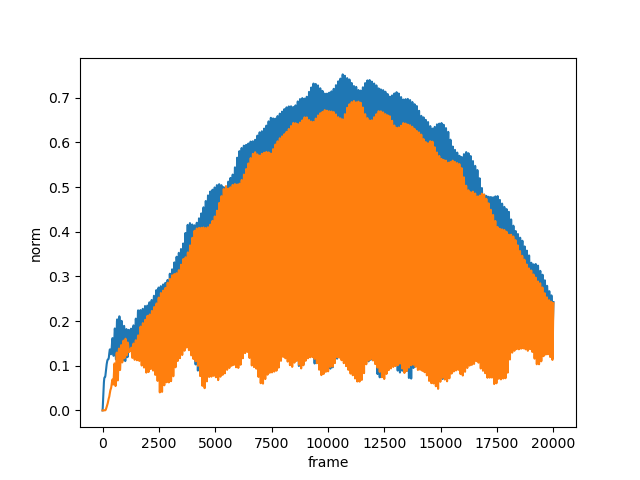

In [112]:
norm = lambda x: np.linalg.norm(x)

norm_uxs = []
norm_uys = []

for k in range(n_t):
    norm_ux = norm(u[k,...,0])
    norm_uy = norm(u[k,...,1])
    norm_uxs.append(norm_ux)
    norm_uys.append(norm_uy)

plt.figure()
plt.plot(norm_uxs, label='$u_x$')
plt.plot(norm_uys, label='$u_y$')
plt.ylabel('norm')
plt.xlabel('frame')
plt.show()

<IPython.core.display.Javascript object>


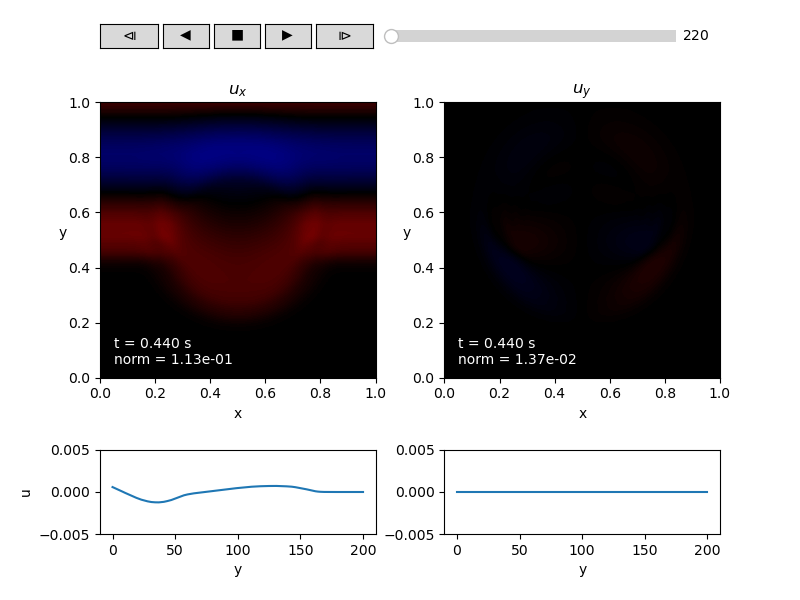

fps = 500.0


In [296]:
%autoreload

from matplotlib import animation
import time

# display wave field simulation

def view1d(u, len_x, ylim, ax, **kwargs):
    line, = ax.plot(u, **kwargs)
    ax.set_ylim(*ylim)
    ax.set_xlabel('y')
    return line

w_map = mre_pinn.visual.wave_color_map()
w_min = -0.005
w_max =  0.005

def view_sim(u, len_x, len_y, dt, player=True):


    mid = n_x // 2
    n_t = u.shape[0]

    fig, axes = plt.subplots(2, 2, figsize=(8,6), gridspec_kw=dict(height_ratios=[8, 2], wspace=0.25))

    txt_ux = axes[0,0].text(0.05, 0.05, f't = 0 s\nnorm = 0', color='white', bbox=dict(facecolor='black', alpha=0.5))
    txt_uy = axes[0,1].text(0.05, 0.05, f't = 0 s\nnorm = 0', color='white', bbox=dict(facecolor='black', alpha=0.5))
    im_ux2 = view2d(u[0,...,0], len_x, len_y, ax=axes[0,0], title='$u_x$', vmin=w_min, vmax=w_max, cmap=w_map)
    im_uy2 = view2d(u[0,...,1], len_x, len_y, ax=axes[0,1], title='$u_y$', vmin=w_min, vmax=w_max, cmap=w_map)
    im_ux1 = view1d(u[0,:,mid,0], len_y, ylim=(w_min, w_max), ax=axes[1,0])
    im_uy1 = view1d(u[0,:,mid,1], len_y, ylim=(w_min, w_max), ax=axes[1,1])
    axes[1,0].set_ylabel('u')
    
    norm_uxs = []
    norm_uys = []

    for k in range(n_t):
        norm_ux = norm(u[k,...,0])
        norm_uy = norm(u[k,...,1])
        norm_uxs.append(norm_ux)
        norm_uys.append(norm_uy)

    def animate_func(k):
        txt_ux.set_text(f't = {k * dt:.03f} s\nnorm = {norm_uxs[k]:.02e}')
        txt_uy.set_text(f't = {k * dt:.03f} s\nnorm = {norm_uys[k]:.02e}')
        im_ux2.set_array(u[k,...,0])
        im_uy2.set_array(u[k,...,1])
        im_ux1.set_ydata(u[k,:,mid,0])
        im_uy1.set_ydata(u[k,:,mid,1])
        return [txt_ux, txt_uy, im_ux2, im_uy2, im_ux1, im_uy1]

    interval = 1000 * dt
    fps = 1000 / interval
    print(f'fps = {fps}')
    if player:
        return mre_pinn.visual.Player(fig, animate_func, frames=n_t, maxi=n_t, interval=interval, repeat=True, blit=True)
    else:
        return animation.FuncAnimation(fig, animate_func, frames=n_t, interval=interval, repeat=True, blit=True)

downsample = 1
anim = view_sim(u[::downsample], len_x, len_y, dt * downsample * 4)

200


<IPython.core.display.Javascript object>


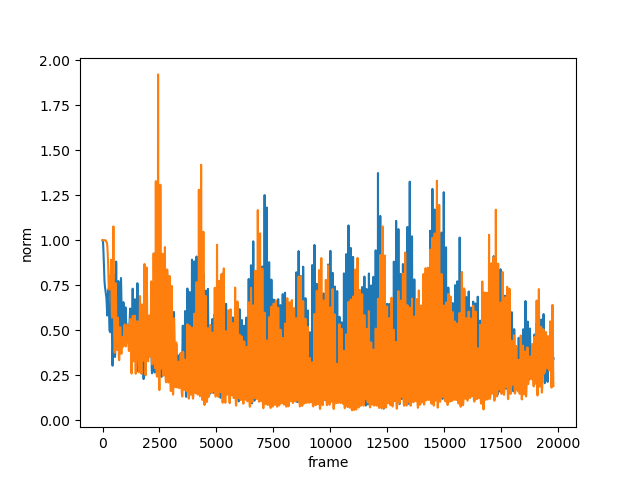

In [233]:
# identify when simulation reached a steady state

frames_per_second  = 1 / dt
seconds_per_radian = 1 / omega
radians_per_period = 2 * np.pi

frames_per_period = int(frames_per_second * seconds_per_radian * radians_per_period)
print(frames_per_period)

dist = np.linalg.norm(u[frames_per_period:] - u[:-frames_per_period], axis=(1,2)) / np.linalg.norm(u[frames_per_period:], axis=(1,2))
dist.shape

plt.figure()
plt.plot(dist[:,0], label='$u_x$')
plt.plot(dist[:,1], label='$u_y$')
plt.ylabel('norm')
plt.xlabel('frame')
plt.show()

In [293]:
# identify FFT time window that minimizes norm of imaginary component of u_x

imag_norms = []
for i in tqdm.tqdm(range(7450, 7550)):
    u_steady = u[i:i+frames_per_period]
    u_complex = np.fft.fftn(u_steady, axes=(0,), norm='forward')
    imag_norm = np.linalg.norm(u_complex[1,...,0].imag)
    imag_norms.append((imag_norm, i))
    
min(imag_norms)

100%|██████████| 100/100 [00:21<00:00,  4.70it/s]


(0.05877060982542791, 7465)

<IPython.core.display.Javascript object>


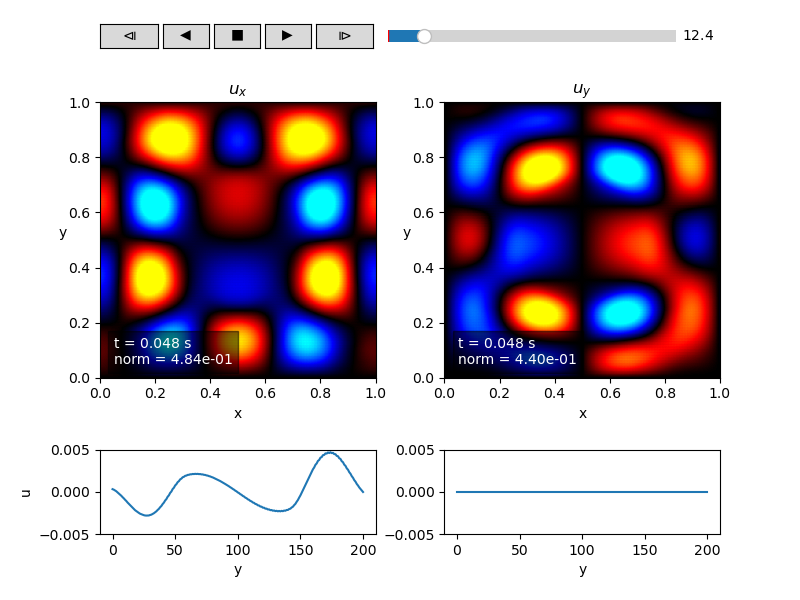

fps = 250.0


In [294]:
# select a single period of steady state wave propagation

i = 7465
u_steady = u[i:i+frames_per_period]

downsample = 2
anim = view_sim(u_steady[::downsample], len_x, len_y, dt * downsample * 4, player=True)

<IPython.core.display.Javascript object>


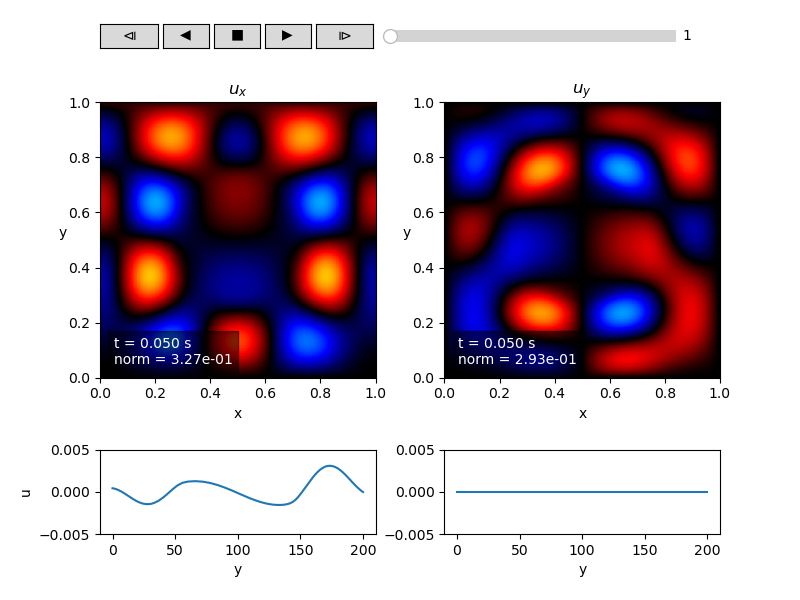

fps = 20.0


In [298]:
# convert to frequency domain using FFT
u_complex = np.fft.fftn(u_steady, axes=(0,), norm='forward')

anim = view_sim(u_complex.real, len_x, len_y, dt * 100, player=True)

<IPython.core.display.Javascript object>


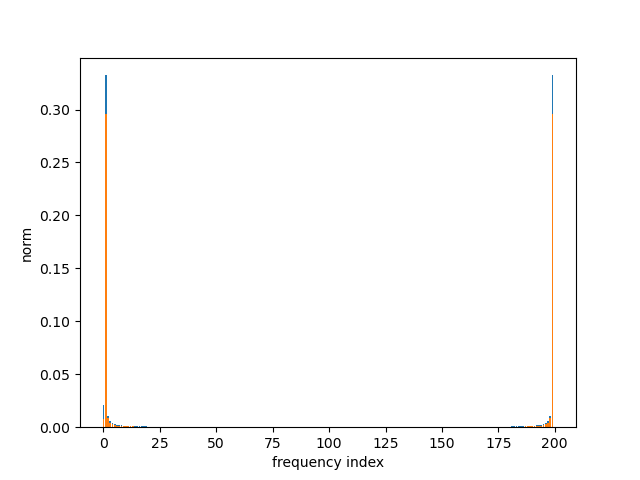

In [300]:
# view the frequency spectrum of the simulation window

freqs = np.linalg.norm(u_complex, axis=(1,2))

n_freqs = freqs.shape[0]
x = np.arange(n_freqs)

plt.figure()
plt.bar(x, freqs[:,0], label='$u_x$')
plt.bar(x, freqs[:,1], label='$u_y$')
plt.ylabel('norm')
plt.xlabel('frequency index')
plt.show()

<IPython.core.display.Javascript object>


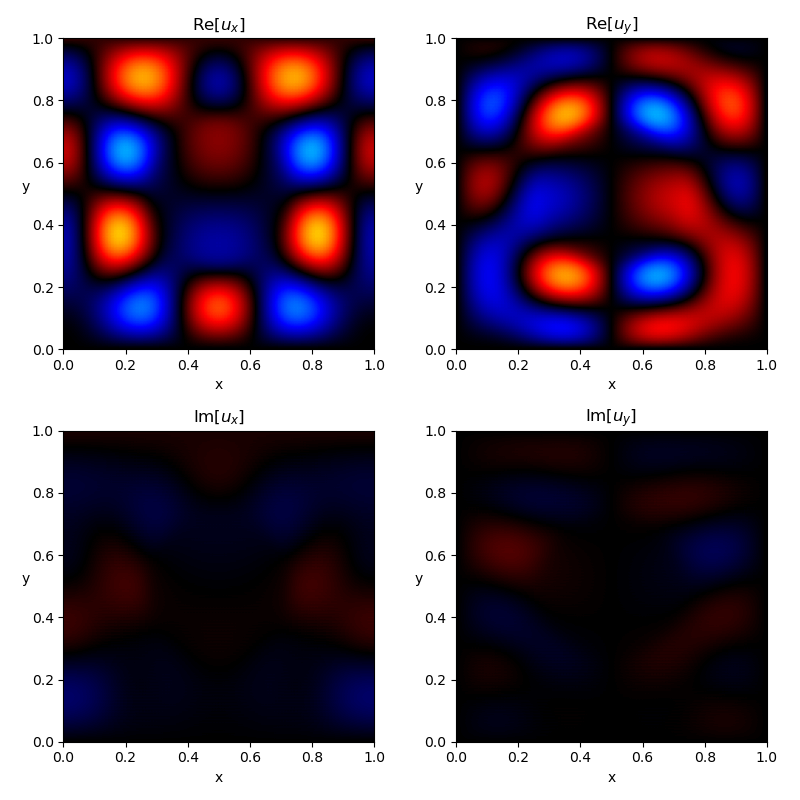

In [309]:
# extract and view the fundamental frequency

w_map = mre_pinn.visual.wave_color_map()
w_min = -0.005
w_max =  0.005

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
view2d(u_complex[1,...,0].real, len_x, len_y, title='Re[$u_x$]', ax=axes[0,0], vmin=w_min, vmax=w_max, cmap=w_map)
view2d(u_complex[1,...,1].real, len_x, len_y, title='Re[$u_y$]', ax=axes[0,1], vmin=w_min, vmax=w_max, cmap=w_map)
view2d(u_complex[1,...,0].imag, len_x, len_y, title='Im[$u_x$]', ax=axes[1,0], vmin=w_min, vmax=w_max, cmap=w_map)
view2d(u_complex[1,...,1].imag, len_x, len_y, title='Im[$u_y$]', ax=axes[1,1], vmin=w_min, vmax=w_max, cmap=w_map)
fig.tight_layout()

In [314]:
%pwd

'/ocean/projects/asc170022p/mtragoza/MRE-PINN'

In [328]:
os.makedirs('data/wave_sim', exist_ok=True)
np.save('data/wave_sim/elasticity.npy', mu)
np.save('data/wave_sim/traveling_wave.npy', u)
np.save('data/wave_sim/steady_state_wave.npy', u_complex[1])

In [345]:
%autoreload

mre_pinn.ImagePointSet('data/wave_sim/steady_state_wave.npy').values.shape

(40401, 2)

In [159]:
%autoreload
plt.rcParams['animation.ffmpeg_path'] = '/home/mtr22/anaconda3/envs/MRE-PINN/bin/ffmpeg'
writer = animation.FFMpegFileWriter(fps=int(1 / dt) // 2)
anim.save('traveling_wave_loop.mp4', writer=writer)

FileNotFoundError: [Errno 2] No such file or directory: '/home/mtr22/anaconda3/envs/MRE-PINN/bin/ffmpeg'